In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

C:\Users\yangman\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 读入数据

In [2]:
data= pd.read_csv('./kc_house_data.csv')

In [3]:
data .head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_living15,yr_built
0,221900.0,3,1.00,1180,5650,1.0,0,7,1180,1340,63
1,538000.0,3,2.25,2570,7242,2.0,0,7,2170,1690,67
2,180000.0,2,1.00,770,10000,1.0,0,6,770,2720,85
3,604000.0,4,3.00,1960,5000,1.0,0,7,1050,1360,53
4,510000.0,3,2.00,1680,8080,1.0,0,8,1680,1800,31


# 相关系数

In [4]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(10, 'price').index
columns

Index(['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15',
       'bathrooms', 'bedrooms', 'waterfront', 'floors', 'sqft_lot'],
      dtype='object')

# 相关系数图

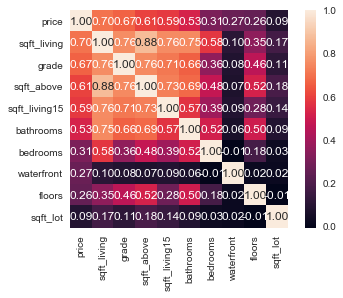

In [5]:
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

# 按4：1的比例划分训练集和测试集

In [6]:
y = data['price'].values
X = data.drop('price', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.20, random_state=22)

# 建立模型
### 计算拟合优度

In [7]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor(n_estimators=400))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=11)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.648658 (0.018682)
ScaledLASSO: 0.648659 (0.018682)
ScaledEN: 0.600459 (0.021018)
ScaledKNN: 0.713287 (0.021275)
ScaledCART: 0.520080 (0.055481)
ScaledGBM: 0.743319 (0.024152)


In [8]:
cv_results

array([0.75783246, 0.75501116, 0.74366733, 0.733968  , 0.73998217,
       0.68982972, 0.72076306, 0.74868517, 0.75804195, 0.78540932])

- GradientBoostingRegressor默认参数
> class sklearn.ensemble.GradientBoostingRegressor(loss=’ls’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)

# 调参

In [10]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,300,400]))
model = GradientBoostingRegressor(random_state=11)
kfold = KFold(n_splits=10, random_state=11)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

0.726750 (0.024039) with: {'n_estimators': 50}
0.736512 (0.025533) with: {'n_estimators': 100}
0.742197 (0.025114) with: {'n_estimators': 200}
0.743708 (0.024628) with: {'n_estimators': 300}
0.744400 (0.024397) with: {'n_estimators': 400}
Best: 0.744400 using {'n_estimators': 400}
